# Demo for MLP

### Import GradLab modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from core.engine import Tensor
from core.nn import Sequential, Linear, ReLU
from core.optim import SGD

### Load & Prepare MNIST Dataset

We load the **MNIST dataset**, which contains handwritten digit images. The pixel values are normalised to the range [0,1] and flattened into 784-dimensional column vectors so they can be fed into a fully connected network.  

The labels are **one-hot encoded** into vectors of length 10 (for digits 0–9), making them compatible with the cross-entropy loss function used during training.

In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize to [0,1] and flatten to vectors
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train = x_train.reshape(-1, 28*28).T
x_test = x_test.reshape(-1, 28*28).T

# One-hot encode labels
num_classes = 10
y_train_oh = np.eye(num_classes)[y_train].T.astype(np.float32)
y_test_oh = np.eye(num_classes)[y_test].T.astype(np.float32)

### Model and Optimiser Definition

The model is built using a **sequential architecture**, where each layer feeds its output directly into the next. It starts with a linear layer that flattens the 28×28 pixel input images into a 784-dimensional vector and projects it into a 128-dimensional hidden layer. A ReLU activation introduces non-linearity, followed by another linear layer mapping to 64 hidden units with another ReLU. Finally, the last linear layer maps these features to the number of output classes (10 prediction labels), producing the logits used for classification.  

The optimiser used is **stochastic gradient descent (SGD)** with a learning rate of 0.01. This optimiser updates the model parameters by moving them in the opposite direction of the gradients computed during backpropagation. By combining this model structure with SGD, the network can iteratively learn representations that minimise the chosen loss function.  

In [3]:
model = Sequential(
    Linear(28*28, 128),
    ReLU(),
    Linear(128, 64),
    ReLU(),
    Linear(64, num_classes)
)

optimizer = SGD(model.parameters(), lr=0.01)

### Loss Definition

The **softmax function** converts the raw model outputs (logits) into probabilities that sum to one across each class. It works by exponentiating the logits (after subtracting the maximum value for numerical stability) and then normalising by the total sum. This makes the outputs interpretable as probabilities for classification tasks. In backpropagation, the Jacobian of softmax is complex, so for simplicity this implementation just propagates gradients directly, which is enough when paired with cross-entropy loss.  

The **cross-entropy loss** measures how well the predicted probability distribution matches the true labels (provided in one-hot form). It computes the negative log likelihood of the correct classes and averages this across the batch. The backward pass provides gradients of the loss with respect to the predicted probabilities, which simplifies to `(pred - target) / batch_size`. This pairing of softmax and cross-entropy is widely used in training classification models.

In [4]:
def softmax(x: Tensor) -> Tensor:
    """
    Returns the softmax of a Tensor

    Args:
        x: a tensor that contains the unnormalised logits (raw model ouput)
    """
    exps = np.exp(x.data - np.max(x.data, axis=0, keepdims=True))
    probs = exps / np.sum(exps, axis=0, keepdims=True)
    out = Tensor(probs, requires_grad=x.requires_grad)

    def _backward():
        """
        Returns the local gradient contribution 
        """
        if x.requires_grad:
            # Jacobian of softmax is messy; for training we usually combine with CE
            # Here we just propagate grads as-is (educational, not optimized)
            x.grad += out.grad
    out._backward = _backward
    out._prev = {x}
    return out

def cross_entropy_loss(pred: Tensor, target: np.ndarray) -> Tensor:
    """
    Computes the Cross Entropy loss
    
    Args:
        pred: a tensor that contains the predicted probability distribution (predicted labels)
        target: one-hot np.ndarray that holds the true probaility distribution (actual labels)
    """
    m = target.shape[1]

    log_likelihood = -np.log(pred.data + 1e-9) * target
    loss_val = np.sum(log_likelihood) / m
    loss = Tensor(loss_val, requires_grad=True)

    def _backward():
        """
        Returns the local gradient contribution 
        """
        if pred.requires_grad:
            pred.grad += (pred.data - target) / m
    loss._backward = _backward
    loss._prev = {pred}
    return loss

### Training Loop

The training loop implements **mini-batch stochastic gradient descent (SGD)**. At the start of each epoch, the dataset is randomly shuffled to ensure batches are sampled in a different order every time, which improves generalisation.

The loop then slices the shuffled data into mini-batches. For each batch, the model performs a forward pass to compute the unnormalised final scores (logits), applies the softmax function to obtain probabilities, and calculates the cross-entropy loss against the true one-hot encoded labels.  

During the backward pass, backpropagation computes the new gradients, and the optimiser updates the model’s weights. After all batches are processed, the model is evaluated on the test set, where the predictions are generated.

In [5]:
epochs = 100
batch_size = 64

# Empty lists for storing datapoints of each variable for plotting
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    perm = np.random.permutation(x_train.shape[1])
    x_train_shuffled = x_train[:, perm]
    y_train_shuffled = y_train_oh[:, perm]

    epoch_losses = []
    for i in range(0, x_train.shape[1], batch_size):
        xb = Tensor(x_train_shuffled[:, i:i+batch_size], requires_grad=False)
        yb = y_train_shuffled[:, i:i+batch_size]

        logits = model(xb)
        probs = softmax(logits)
        loss = cross_entropy_loss(probs, yb)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.data)
    avg_loss = np.mean(epoch_losses)

    # Evaluate accuracy
    test_logits = model(Tensor(x_test, requires_grad=False))
    test_probs = softmax(test_logits)
    test_preds = np.argmax(test_probs.data, axis=0)
    acc = np.mean(test_preds == y_test)

    # Append datapoints (average loss & test accuracy) for each epoch
    train_losses.append(avg_loss)
    test_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Test Acc: {acc:.4f}")

Epoch 1/100, Loss: 2.3016, Test Acc: 0.1135
Epoch 2/100, Loss: 2.3001, Test Acc: 0.1135
Epoch 3/100, Loss: 2.2937, Test Acc: 0.2012
Epoch 4/100, Loss: 2.0810, Test Acc: 0.3875
Epoch 5/100, Loss: 1.4131, Test Acc: 0.5588
Epoch 6/100, Loss: 0.9851, Test Acc: 0.7391
Epoch 7/100, Loss: 0.7261, Test Acc: 0.8096
Epoch 8/100, Loss: 0.5752, Test Acc: 0.8520
Epoch 9/100, Loss: 0.4785, Test Acc: 0.8729
Epoch 10/100, Loss: 0.4230, Test Acc: 0.8859
Epoch 11/100, Loss: 0.3876, Test Acc: 0.8910
Epoch 12/100, Loss: 0.3628, Test Acc: 0.8966
Epoch 13/100, Loss: 0.3440, Test Acc: 0.9014
Epoch 14/100, Loss: 0.3287, Test Acc: 0.9048
Epoch 15/100, Loss: 0.3154, Test Acc: 0.9086
Epoch 16/100, Loss: 0.3042, Test Acc: 0.9111
Epoch 17/100, Loss: 0.2949, Test Acc: 0.9140
Epoch 18/100, Loss: 0.2862, Test Acc: 0.9171
Epoch 19/100, Loss: 0.2789, Test Acc: 0.9182
Epoch 20/100, Loss: 0.2728, Test Acc: 0.9200
Epoch 21/100, Loss: 0.2672, Test Acc: 0.9227
Epoch 22/100, Loss: 0.2626, Test Acc: 0.9239
Epoch 23/100, Loss:

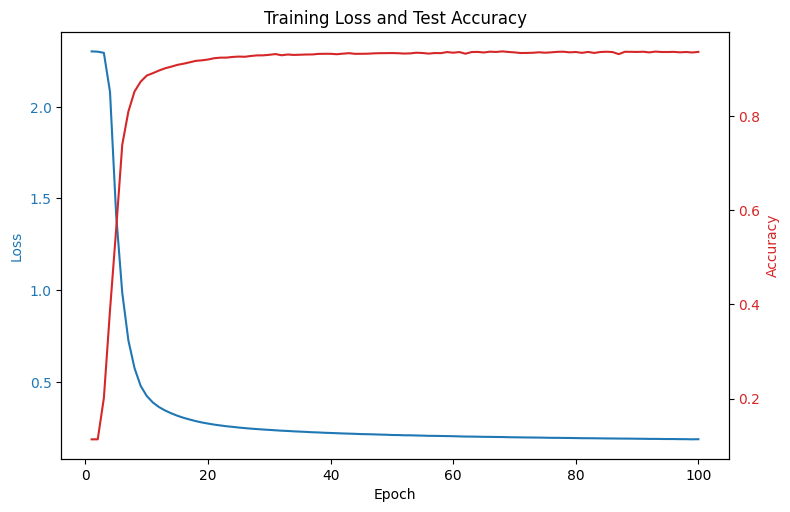

In [6]:
# Plot Loss and Accuracy
fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, epochs+1), train_losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(1, epochs+1), test_accuracies, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Test Accuracy')
plt.show()

### Testing MLP model

Random Sample Prediction -> True: 9, Pred: 9
Model Certainty: 0.99103844165802


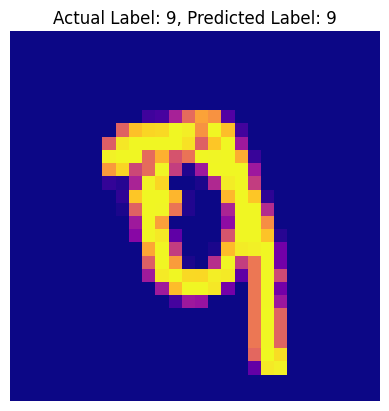

In [8]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, x_test.shape[1])

x_sample = Tensor(x_test[:, idx:idx+1], requires_grad=False)
logits = model(x_sample)
probs = softmax(logits)

pred_label = int(np.argmax(probs.data, axis=0).item())
true_label = int(y_test[idx])

print(f"Random Sample Prediction -> True: {true_label}, Pred: {pred_label}\nModel Certainty: {np.max(probs.data)}")

plt.imshow(x_test[:, idx].reshape(28, 28), cmap="plasma")
plt.title(f"Actual Label: {true_label}, Predicted Label: {pred_label}")
plt.axis("off")
plt.show()